In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# modify the path below accordingly
PATH = "/content/drive/MyDrive/compvision/gesture_face_features"

In [195]:
# importing .py files from /code
import sys
import os
sys.path.append(os.path.join(PATH, "code"))

%load_ext autoreload
%autoreload 2

from utils import show_img
from config import Config
from heatmap import *
from hand_extraction import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
conf = Config(PATH, img_type="sign", load_data=True, shuffle=False, letter= "A")
conf

Loading data...
Data loaded successfully.
Setting up model InceptionV3...
Model was set up successfully.


Config(
  img_type=both,
  model_name=InceptionV3,
  load_data=True,
  shuffle=False,
  img_count=38,
  letter=A,
  input_size=296,
  input_dim=(299, 299),
  feats=2048,
  feat_layer=-3
)

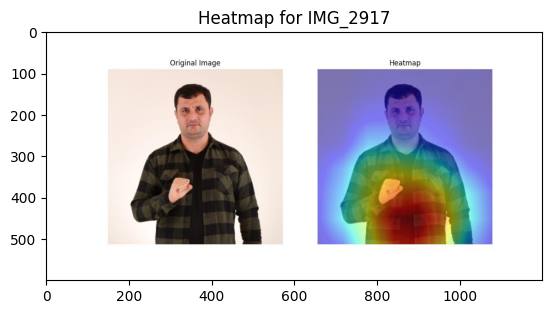

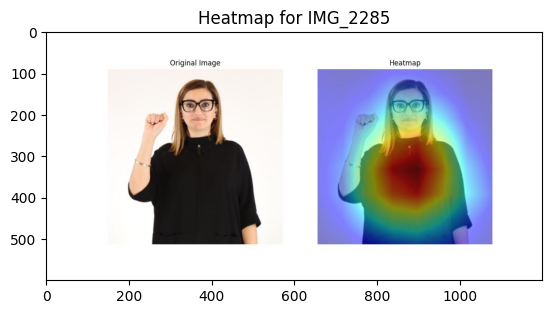

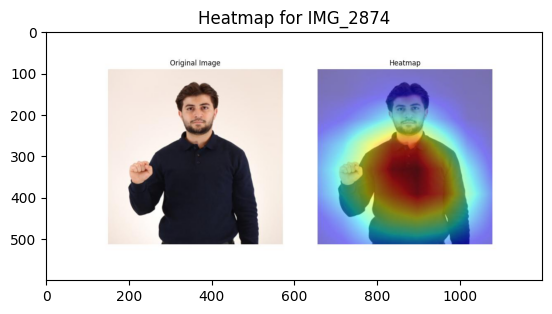

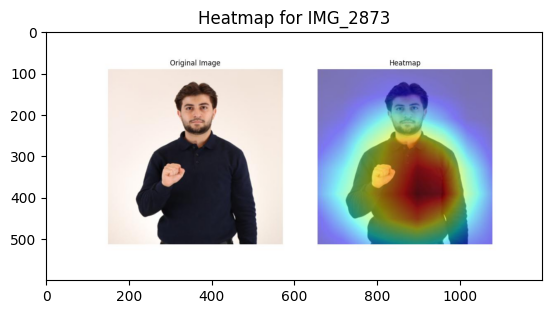

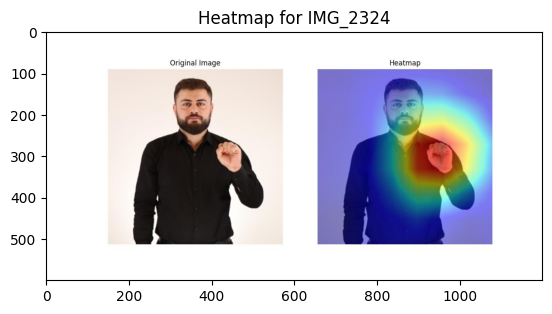

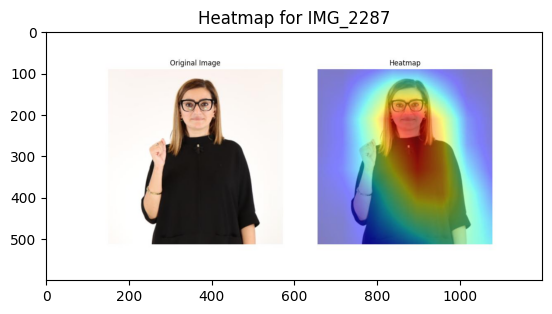

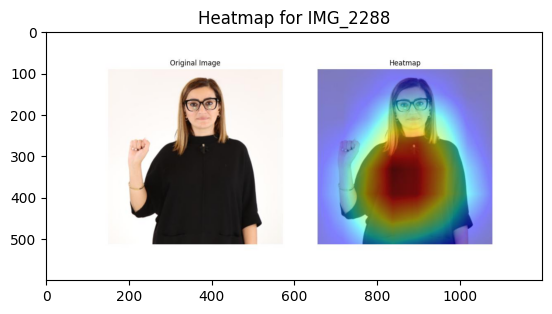

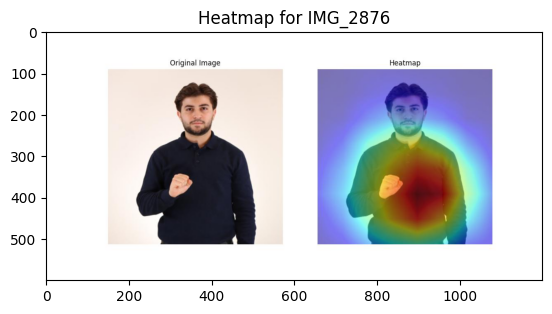

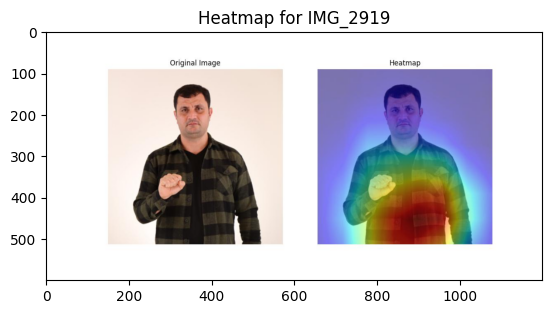

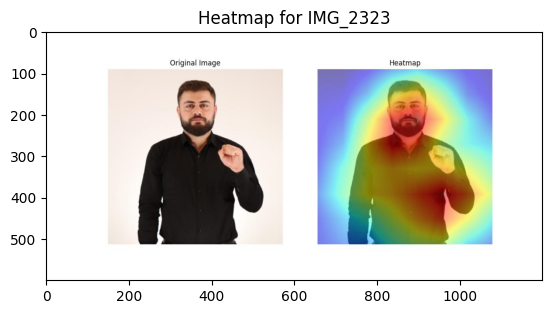

In [206]:
# generate_heatmaps(conf.sign_imgs, conf.input_dim, *conf.heatmap_config, heatmaps_path=conf.heatmaps_path)
load_heatmaps(conf.sign_imgs[15:25], conf.heatmaps_path)

In [204]:
extract_hand_md(conf.sign_imgs)
extract_hand_md(conf.sign_imgs, conf.input_dim)

Output hidden; open in https://colab.research.google.com to view.